In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
sys.path.append('../utils')

In [16]:
data=pd.read_csv('../data/expanded_crsp_stock_data.csv')
# data=pd.read_csv('../data/NVDA_30min_sample.csv')
data

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_7697/633468767.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('../data/expanded_crsp_stock_data.csv')


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD
0,10001,2000-01-03,EWST,8.43750,8.5625,8.56250,1721.0,0.007353,2450.0,1.5,1.5,8.4375,2.0
1,10001,2000-01-04,EWST,8.43750,8.4375,8.43750,1080.0,-0.014599,2450.0,1.5,1.5,8.4375,2.0
2,10001,2000-01-05,EWST,8.43750,8.5625,8.56250,1711.0,0.014815,2450.0,1.5,1.5,8.4375,5.0
3,10001,2000-01-06,EWST,8.50000,8.5000,8.50000,580.0,-0.007299,2450.0,1.5,1.5,8.5000,2.0
4,10001,2000-01-07,EWST,8.43750,8.5625,8.43750,1406.0,-0.007353,2450.0,1.5,1.5,8.5625,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30424636,93436,2016-12-23,TSLA,207.71001,213.4500,213.34000,4670464.0,0.023459,149964.0,15.0,15.0,208.0000,34811.0
30424637,93436,2016-12-27,TSLA,214.42000,222.2500,219.53000,5915732.0,0.029015,149964.0,15.0,15.0,214.8800,52047.0
30424638,93436,2016-12-28,TSLA,217.20000,223.8000,219.74001,3782456.0,0.000957,149964.0,15.0,15.0,221.5300,34140.0
30424639,93436,2016-12-29,TSLA,214.12250,219.2000,214.67999,4044968.0,-0.023027,149964.0,15.0,15.0,218.5600,34316.0


In [17]:
data=data.drop(['NUMTRD'],axis=1)

In [18]:
data

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,OPENPRC
0,10001,2000-01-03,EWST,8.43750,8.5625,8.56250,1721.0,0.007353,2450.0,1.5,1.5,8.4375
1,10001,2000-01-04,EWST,8.43750,8.4375,8.43750,1080.0,-0.014599,2450.0,1.5,1.5,8.4375
2,10001,2000-01-05,EWST,8.43750,8.5625,8.56250,1711.0,0.014815,2450.0,1.5,1.5,8.4375
3,10001,2000-01-06,EWST,8.50000,8.5000,8.50000,580.0,-0.007299,2450.0,1.5,1.5,8.5000
4,10001,2000-01-07,EWST,8.43750,8.5625,8.43750,1406.0,-0.007353,2450.0,1.5,1.5,8.5625
...,...,...,...,...,...,...,...,...,...,...,...,...
30424636,93436,2016-12-23,TSLA,207.71001,213.4500,213.34000,4670464.0,0.023459,149964.0,15.0,15.0,208.0000
30424637,93436,2016-12-27,TSLA,214.42000,222.2500,219.53000,5915732.0,0.029015,149964.0,15.0,15.0,214.8800
30424638,93436,2016-12-28,TSLA,217.20000,223.8000,219.74001,3782456.0,0.000957,149964.0,15.0,15.0,221.5300
30424639,93436,2016-12-29,TSLA,214.12250,219.2000,214.67999,4044968.0,-0.023027,149964.0,15.0,15.0,218.5600


In [19]:
# total_days = data['date'].nunique()

# # Calculate the 80% threshold of the total days
# threshold = 0.2 * total_days

# # Count the number of days for each ticker
# ticker_days = data.groupby('TICKER')['date'].nunique()

# # Filter tickers that have at least 80% of the total days
# tickers_above_threshold = ticker_days[ticker_days >= threshold].index

# # Filter the DataFrame to only include these tickers
# filtered_df = data[data['TICKER'].isin(tickers_above_threshold)]

In [20]:
# Count unique tickers per day
unique_tickers_per_day = data.groupby('date')['TICKER'].nunique()

# Print the result
unique_tickers_per_day

date
2000-01-03    8303
2000-01-04    8302
2000-01-05    8301
2000-01-06    8301
2000-01-07    8298
              ... 
2016-12-23    7164
2016-12-27    7163
2016-12-28    7162
2016-12-29    7163
2016-12-30    7173
Name: TICKER, Length: 4295, dtype: int64

In [21]:
# data=filtered_df

In [22]:
data['RET'] = pd.to_numeric(data['RET'], errors='coerce')

# Drop rows where 'RET' is NA after conversion
data.dropna(subset=['RET'], inplace=True)

In [23]:

data

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,OPENPRC
0,10001,2000-01-03,EWST,8.43750,8.5625,8.56250,1721.0,0.007353,2450.0,1.5,1.5,8.4375
1,10001,2000-01-04,EWST,8.43750,8.4375,8.43750,1080.0,-0.014599,2450.0,1.5,1.5,8.4375
2,10001,2000-01-05,EWST,8.43750,8.5625,8.56250,1711.0,0.014815,2450.0,1.5,1.5,8.4375
3,10001,2000-01-06,EWST,8.50000,8.5000,8.50000,580.0,-0.007299,2450.0,1.5,1.5,8.5000
4,10001,2000-01-07,EWST,8.43750,8.5625,8.43750,1406.0,-0.007353,2450.0,1.5,1.5,8.5625
...,...,...,...,...,...,...,...,...,...,...,...,...
30424636,93436,2016-12-23,TSLA,207.71001,213.4500,213.34000,4670464.0,0.023459,149964.0,15.0,15.0,208.0000
30424637,93436,2016-12-27,TSLA,214.42000,222.2500,219.53000,5915732.0,0.029015,149964.0,15.0,15.0,214.8800
30424638,93436,2016-12-28,TSLA,217.20000,223.8000,219.74001,3782456.0,0.000957,149964.0,15.0,15.0,221.5300
30424639,93436,2016-12-29,TSLA,214.12250,219.2000,214.67999,4044968.0,-0.023027,149964.0,15.0,15.0,218.5600


In [24]:
import pandas as pd

# # Step 1: Convert 'date' to datetime and create 'MonthYear'
data['date'] = pd.to_datetime(data['date'])
data['MonthYear'] = data['date'].dt.to_period('M')

# Step 2: Adjust for splits and calculate Adjusted Market Cap
data['AdjPRC'] = data['PRC'] / data['CFACPR']
data['AdjSHROUT'] = data['SHROUT'] * data['CFACSHR']
data['AdjMktCap'] = data['AdjPRC'] * data['AdjSHROUT']
data['AdjMktCap'] = pd.to_numeric(data['AdjMktCap'], errors='coerce')
data = data.dropna(subset=['AdjMktCap'])

# Step 3: Calculate the 30-day rolling standard deviation of returns
data['avg_vol_30d'] = data.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=30).std())

# Step 4: Identify the last trading day of each month
data['is_last_trading_day'] = data['date'] == data.groupby('MonthYear')['date'].transform('max')

# Step 5: Calculate volatility decile for next month (using data from the last trading day)
# Ensure to calculate on the last trading day of each month
last_day_data = data[data['is_last_trading_day']]
last_day_data['volatility_decile'] = last_day_data.groupby('MonthYear')['avg_vol_30d'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Filter the last trading day of the month and select top 1000 by Market Cap
top_1000_prev_month = last_day_data.groupby('MonthYear').apply(lambda x: x.nlargest(1000, 'AdjMktCap')).reset_index(drop=True)

# Step 6: Merge the decile data back to the original dataset
# As we have data for next month's decile calculated, we will shift the MonthYear for merging
top_1000_prev_month['MonthYear'] = top_1000_prev_month['MonthYear'] + 1

data_with_decile = data.merge(top_1000_prev_month[['MonthYear', 'TICKER', 'volatility_decile']], on=['MonthYear', 'TICKER'], how='left')

# Optional: Drop rows with missing deciles (potentially due to not being in top 1000)
data_with_decile = data_with_decile.dropna(subset=['volatility_decile'])

# print(data_with_decile.head())
# data['date'] = pd.to_datetime(data['date'])
# data['MonthYear'] = data['date'].dt.to_period('M')

# # Step 2: Adjust for splits and calculate Adjusted Market Cap
# data['AdjPRC'] = data['PRC'] / data['CFACPR']
# data['AdjSHROUT'] = data['SHROUT'] * data['CFACSHR']
# data['AdjMktCap'] = data['AdjPRC'] * data['AdjSHROUT']
# data['AdjMktCap'] = pd.to_numeric(data['AdjMktCap'], errors='coerce')
# data.dropna(subset=['AdjMktCap'], inplace=True)

# # Step 3: Calculate the 30-day rolling standard deviation of returns
# data['avg_vol_30d'] = data.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# # Step 4: Identify the last trading day of each month
# data['is_last_trading_day'] = data['date'] == data.groupby('MonthYear')['date'].transform('max')

# # Step 5: Calculate volatility decile for next month (using data from the last trading day)
# # Ensure to calculate on the last trading day of each month
# last_day_data = data[data['is_last_trading_day']].copy()
# last_day_data['volatility_decile'] = last_day_data.groupby('MonthYear')['avg_vol_30d'].transform(
#     lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# # Filter the last trading day of the month and select top 1000 by Market Cap
# top_1000_prev_month = last_day_data.groupby('MonthYear').apply(lambda x: x.nlargest(1000, 'AdjMktCap')).reset_index(drop=True)

# # Step 6: Merge the decile data back to the original dataset for next month's trading
# # Increment 'MonthYear' for matching to next month's data
# top_1000_prev_month['MonthYear'] = top_1000_prev_month['MonthYear'] + 1

# data_with_decile = data.merge(top_1000_prev_month[['MonthYear', 'TICKER', 'volatility_decile']], on=['MonthYear', 'TICKER'], how='left')

# # Optional: Drop rows with missing deciles (potentially due to not being in top 1000)
# data_with_decile = data_with_decile.dropna(subset=['volatility_decile'])

# print(data_with_decile.head())

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_7697/259398457.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_vol_30d'] = data.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=30).std())
/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_7697/259398457.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_last_trading_day'] = data['date'] == data.groupby('MonthYear')['date'].transform('max')
/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_76

In [25]:
data_with_decile.sort_values(by=['TICKER', 'date'], inplace=True)

# Shift the decile data to compare with the previous month's decile for each ticker
data_with_decile['prev_decile'] = data_with_decile.groupby('TICKER')['volatility_decile'].shift(1)

# Create a flag column to indicate whether the decile has changed from the previous month
data_with_decile['decile_changed'] = data_with_decile['volatility_decile'] != data_with_decile['prev_decile']
monthly_turnover = data_with_decile.groupby('MonthYear')['decile_changed'].mean()

print(monthly_turnover)


MonthYear
2000-02    0.045205
2000-03    0.042189
2000-04    0.041327
2000-05    0.046953
2000-06    0.025297
             ...   
2016-08    0.026394
2016-09    0.047101
2016-10    0.036322
2016-11    0.035790
2016-12    0.038803
Freq: M, Name: decile_changed, Length: 203, dtype: float64


In [26]:
# Ensure the data is sorted by date
data_with_decile.sort_values(by=['TICKER', 'date'], inplace=True)

# Group by 'MonthYear' and 'TICKER', and check if all entries within each group are the same
decile_consistency = data_with_decile.groupby(['MonthYear', 'TICKER'])['volatility_decile'].nunique()

# We are looking for cases where the number of unique deciles per group is more than 1, which would mean inconsistency
inconsistent_deciles = decile_consistency[decile_consistency > 1]

# Calculate the percentage of ticker-month groups that have consistent deciles
consistency_rate = (1 - len(inconsistent_deciles) / len(decile_consistency)) * 100
print("Decile Consistency Rate: {:.2f}%".format(consistency_rate))


Decile Consistency Rate: 99.90%


In [23]:
data_with_decile[data_with_decile['TICKER']=='TSLA']

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,OPENPRC,MonthYear,AdjPRC,AdjSHROUT,AdjMktCap,avg_vol_30d,is_last_trading_day,volatility_decile
29861307,93436,2010-12-01,TSLA,33.45000,36.4200,34.35000,1333370.0,-0.027739,93271.0,15.0,15.0,35.87,2010-12,2.290000,1399065.0,3.203859e+06,0.049797,False,9.0
29861308,93436,2010-12-02,TSLA,31.20000,34.2975,32.35000,2044936.0,-0.058224,93271.0,15.0,15.0,34.01,2010-12,2.156667,1399065.0,3.017317e+06,0.051708,False,9.0
29861309,93436,2010-12-03,TSLA,30.87000,32.2500,31.49000,1188447.0,-0.026584,93271.0,15.0,15.0,32.01,2010-12,2.099333,1399065.0,2.937104e+06,0.052263,False,9.0
29861310,93436,2010-12-06,TSLA,29.56000,31.4500,30.31000,1307036.0,-0.037472,93271.0,15.0,15.0,31.35,2010-12,2.020667,1399065.0,2.827044e+06,0.053067,False,9.0
29861311,93436,2010-12-07,TSLA,30.05000,32.4000,31.56000,1336869.0,0.041241,93271.0,15.0,15.0,30.49,2010-12,2.104000,1399065.0,2.943633e+06,0.053274,False,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29862834,93436,2016-12-23,TSLA,207.71001,213.4500,213.34000,4670464.0,0.023459,149964.0,15.0,15.0,208.00,2016-12,14.222667,2249460.0,3.199332e+07,0.020448,False,5.0
29862835,93436,2016-12-27,TSLA,214.42000,222.2500,219.53000,5915732.0,0.029015,149964.0,15.0,15.0,214.88,2016-12,14.635333,2249460.0,3.292160e+07,0.020801,False,5.0
29862836,93436,2016-12-28,TSLA,217.20000,223.8000,219.74001,3782456.0,0.000957,149964.0,15.0,15.0,221.53,2016-12,14.649334,2249460.0,3.295309e+07,0.019180,False,5.0
29862837,93436,2016-12-29,TSLA,214.12250,219.2000,214.67999,4044968.0,-0.023027,149964.0,15.0,15.0,218.56,2016-12,14.311999,2249460.0,3.219427e+07,0.019882,False,5.0


In [14]:
# Count unique tickers per day
unique_tickers_per_day = data_with_decile.groupby('date')['TICKER'].nunique()

unique_tickers_per_day

date
2000-02-01    993
2000-02-02    991
2000-02-03    992
2000-02-04    992
2000-02-07    991
             ... 
2016-12-23    993
2016-12-27    993
2016-12-28    993
2016-12-29    993
2016-12-30    993
Name: TICKER, Length: 4257, dtype: int64

In [15]:
resulting_df=data_with_decile

In [16]:

market_daily = resulting_df.groupby('date').agg({
    'RET': 'median',  # or use 'mean' depending on what's considered 'market average'
    'VOL': 'median'  # or 'mean'
}).rename(columns={'RET': 'Market_RET_Median', 'VOL': 'Market_VOL_Median'})
resulting_df = resulting_df.merge(market_daily, left_on='date', right_index=True)



In [17]:
resulting_df

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,...,OPENPRC,MonthYear,AdjPRC,AdjSHROUT,AdjMktCap,avg_vol_30d,is_last_trading_day,volatility_decile,Market_RET_Median,Market_VOL_Median
22958,10032,2000-07-03,PLXS,110.43750,118.9375,118.25000,194439.0,0.046460,18350.0,2.0,...,112.3750,2000-07,59.125000,36700.0,2.169888e+06,0.046862,False,6.0,0.013084,339500.0
22959,10032,2000-07-05,PLXS,115.00000,122.0000,116.50000,628257.0,-0.014799,18350.0,2.0,...,119.6250,2000-07,58.250000,36700.0,2.137775e+06,0.046911,False,6.0,-0.007968,718554.0
22960,10032,2000-07-06,PLXS,108.75000,117.2500,111.50000,354710.0,-0.042918,18350.0,2.0,...,117.2500,2000-07,55.750000,36700.0,2.046025e+06,0.047116,False,6.0,0.005000,729900.0
22961,10032,2000-07-07,PLXS,111.00000,117.5000,117.00000,410906.0,0.049327,18350.0,2.0,...,111.4375,2000-07,58.500000,36700.0,2.146950e+06,0.045845,False,6.0,0.010155,761100.0
22962,10032,2000-07-10,PLXS,118.25000,123.2500,122.00000,338699.0,0.042735,18350.0,2.0,...,119.0000,2000-07,61.000000,36700.0,2.238700e+06,0.043571,False,6.0,0.000000,690100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29862834,93436,2016-12-23,TSLA,207.71001,213.4500,213.34000,4670464.0,0.023459,149964.0,15.0,...,208.0000,2016-12,14.222667,2249460.0,3.199332e+07,0.020448,False,5.0,0.001498,815999.0
29862835,93436,2016-12-27,TSLA,214.42000,222.2500,219.53000,5915732.0,0.029015,149964.0,15.0,...,214.8800,2016-12,14.635333,2249460.0,3.292160e+07,0.020801,False,5.0,0.002478,847020.0
29862836,93436,2016-12-28,TSLA,217.20000,223.8000,219.74001,3782456.0,0.000957,149964.0,15.0,...,221.5300,2016-12,14.649334,2249460.0,3.295309e+07,0.019180,False,5.0,-0.008400,1009005.0
29862837,93436,2016-12-29,TSLA,214.12250,219.2000,214.67999,4044968.0,-0.023027,149964.0,15.0,...,218.5600,2016-12,14.311999,2249460.0,3.219427e+07,0.019882,False,5.0,0.000905,963328.0


In [18]:
resulting_df['Relative_RET'] = (1 + resulting_df['RET']) / (1 + resulting_df['Market_RET_Median']) - 1
resulting_df['Relative_VOL'] = resulting_df['VOL'] / resulting_df['Market_VOL_Median']

In [19]:
resulting_df=resulting_df.dropna()

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_90122/3869426278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulting_df['volatility_decile'] = pd.Categorical(resulting_df['volatility_decile'], categories=sorted(resulting_df['volatility_decile'].unique()), ordered=True)


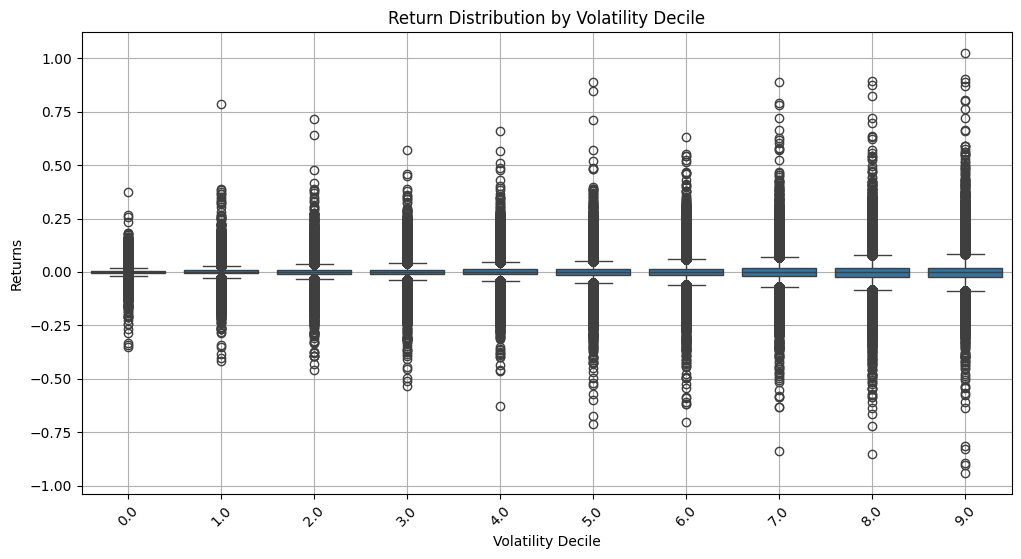

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
resulting_df['volatility_decile'] = pd.Categorical(resulting_df['volatility_decile'], categories=sorted(resulting_df['volatility_decile'].unique()), ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='volatility_decile', y='RET', data=resulting_df)
plt.title('Return Distribution by Volatility Decile')
plt.xlabel('Volatility Decile')
plt.ylabel('Returns')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(True)
plt.show()

In [21]:
resulting_df['date'] = pd.to_datetime(resulting_df['date'])

# Filter the DataFrame for dates on or after March 1, 2000
resulting_df = resulting_df[resulting_df['date'] >= datetime(2000, 3, 1)]

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_90122/2178239308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulting_df['date'] = pd.to_datetime(resulting_df['date'])


In [22]:
resulting_df['volatility_decile'].value_counts()

volatility_decile
2.0    777849
3.0    714960
1.0    681209
4.0    596604
5.0    466780
6.0    341979
0.0    274064
7.0    234488
8.0    134811
9.0     50650
Name: count, dtype: int64

In [20]:
# Count unique tickers per day
unique_tickers_per_day = resulting_df.groupby('date')['TICKER'].nunique()

# Print the result
dates_with_fewer_than_200_tickers = (unique_tickers_per_day < 200).sum()
dates_with_fewer_than_200_tickers

0

In [21]:
unique_tickers_per_day

date
2000-03-01    974
2000-03-02    974
2000-03-03    973
2000-03-06    974
2000-03-07    973
             ... 
2016-12-23    992
2016-12-27    992
2016-12-28    992
2016-12-29    992
2016-12-30    992
Name: TICKER, Length: 4237, dtype: int64

In [22]:
# #Rename and form WQ columns
wq_alphas=resulting_df.rename(columns={
    'OPENPRC': 'S_DQ_OPEN', 
    'ASKHI': 'S_DQ_HIGH', 
    'BIDLO': 'S_DQ_LOW', 
    'PRC': 'S_DQ_CLOSE', 
    'VOL': 'S_DQ_VOLUME', 
    'RET': 'S_DQ_PCTCHANGE',
})
wq_alphas=wq_alphas[['date','TICKER','S_DQ_OPEN','S_DQ_HIGH','S_DQ_LOW','S_DQ_CLOSE','S_DQ_VOLUME','S_DQ_PCTCHANGE']]
wq_alphas

,date,TICKER,S_DQ_OPEN,S_DQ_HIGH,S_DQ_LOW,S_DQ_CLOSE,S_DQ_VOLUME,S_DQ_PCTCHANGE
20940,2000-06-01,PLXS,84.9375,90.875,84.56250,89.62500,487121.0,0.073353
20941,2000-06-02,PLXS,91.3750,94.125,85.87500,89.93750,504282.0,0.003487
20942,2000-06-05,PLXS,92.0000,95.750,90.59375,94.81250,374249.0,0.054204
20943,2000-06-06,PLXS,95.5000,95.750,92.75000,94.34375,246006.0,-0.004944
20944,2000-06-07,PLXS,93.2500,95.625,89.62500,95.62500,249244.0,0.013581
...,...,...,...,...,...,...,...,...
27309771,2016-12-23,TSLA,208.0000,213.450,207.71001,213.34000,4670464.0,0.023459
27309772,2016-12-27,TSLA,214.8800,222.250,214.42000,219.53000,5915732.0,0.029015
27309773,2016-12-28,TSLA,221.5300,223.800,217.20000,219.74001,3782456.0,0.000957
27309774,2016-12-29,TSLA,218.5600,219.200,214.12250,214.67999,4044968.0,-0.023027


In [23]:
# wq_alphas['S_DQ_VOLUME'] = wq_alphas['S_DQ_VOLUME'] 

# # Calculate S_DQ_AMOUNT as the product of S_DQ_CLOSE and S_DQ_VOLUME
# wq_alphas['S_DQ_AMOUNT'] = wq_alphas['S_DQ_CLOSE'] * wq_alphas['S_DQ_VOLUME']

# # Calculate VWAP
wq_alphas['vwap'] = wq_alphas['S_DQ_AMOUNT'] / wq_alphas['S_DQ_VOLUME']

KeyError: 'S_DQ_AMOUNT'

In [24]:
# wq_alphas.to_csv('wq_alphas_modern.csv')

In [25]:
# from wq_alpha_generator import get_alpha
# def apply_get_alpha_to_each_stock(group_df):
#     return get_alpha(group_df)

# # Group by 'TICKER' and apply the function
# result_df = wq_alphas.groupby('TICKER').apply(apply_get_alpha_to_each_stock).reset_index(drop=True)


In [26]:
# df=pd.read_csv('../wq_alphas.csv')

In [27]:
# df.sort_values(by=['TICKER', 'date'], inplace=True)


In [28]:
# resulting_df=resulting_df.drop(['NUMTRD'],axis=1)

In [24]:
resulting_df['Previous Close'] = resulting_df['PRC'].shift(1)
resulting_df['High_Low'] = resulting_df['ASKHI'] - resulting_df['BIDLO']
resulting_df['High_PrevClose'] = abs(resulting_df['ASKHI'] - resulting_df['PRC'])
resulting_df['Low_PrevClose'] = abs(resulting_df['BIDLO'] - resulting_df['PRC'])

resulting_df['TR'] = resulting_df[['High_Low', 'High_PrevClose', 'Low_PrevClose']].max(axis=1)

# Calculate the ATR
resulting_df['ATR'] = resulting_df['TR'].rolling(window=14).mean()
# resulting_df['hist_vol_30d'] = resulting_df['RET'].rolling(window=30).std()


In [25]:
resulting_df['date'] = pd.to_datetime(resulting_df['date'])

# Sort data by date for consistency
resulting_df.sort_values(by='date', inplace=True)

# Group by date and then select the top 250 stocks based on ATR for each day
# top250_atr_daily = resulting_df.groupby('date').apply(lambda x: x.nlargest(250, 'NUMTRD')).reset_index(drop=True)

In [26]:
resulting_df.columns

Index(['PERMNO', 'date', 'TICKER', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET',
       'SHROUT', 'CFACPR', 'CFACSHR', 'OPENPRC', 'MonthYear', 'AdjPRC',
       'AdjSHROUT', 'AdjMktCap', 'avg_vol_30d', 'is_last_trading_day',
       'volatility_decile', 'Market_RET_Median', 'Market_VOL_Median',
       'Relative_RET', 'Relative_VOL', 'Previous Close', 'High_Low',
       'High_PrevClose', 'Low_PrevClose', 'TR', 'ATR'],
      dtype='object')

In [27]:
# Count unique tickers per day
unique_tickers_per_day = resulting_df.groupby('date')['TICKER'].nunique()

# Print the result
unique_tickers_per_day

date
2000-03-01    991
2000-03-02    990
2000-03-03    988
2000-03-06    988
2000-03-07    988
             ... 
2016-12-23    993
2016-12-27    993
2016-12-28    993
2016-12-29    993
2016-12-30    993
Name: TICKER, Length: 4237, dtype: int64

In [28]:
# Ensure 'date' is in datetime format (if not already)
resulting_df['date'] = pd.to_datetime(resulting_df['date'])

# Filter the DataFrame for the year 2004
df_2004 = resulting_df[resulting_df['date'].dt.year == 2004]

# Group by 'date' and count unique 'TICKER' values for each day
unique_tickers_per_day_2004 = df_2004.groupby('date')['TICKER'].nunique()

# Print the result
print(unique_tickers_per_day_2004)


date
2004-01-02    992
2004-01-05    992
2004-01-06    991
2004-01-07    991
2004-01-08    990
             ... 
2004-12-27    994
2004-12-28    994
2004-12-29    994
2004-12-30    994
2004-12-31    994
Name: TICKER, Length: 252, dtype: int64


In [29]:
resulting_df=resulting_df.drop(['Previous Close','High_Low','High_PrevClose','Low_PrevClose'],axis=1)

In [30]:
resulting_df


,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,...,AdjMktCap,avg_vol_30d,is_last_trading_day,volatility_decile,Market_RET_Median,Market_VOL_Median,Relative_RET,Relative_VOL,TR,ATR
15641128,83623,2000-03-01,ASTSF,29.50000,30.875,30.6250,174975.0,0.020833,80958.0,1.000000,...,2.479339e+06,0.035253,False,4.0,0.009524,962800.0,0.011202,0.181736,1.37500,1.283571
6958131,58393,2000-03-01,RLR,27.62500,29.000,28.4375,1055899.0,0.017897,88535.0,1.000000,...,2.517714e+06,0.033896,False,4.0,0.009524,962800.0,0.008294,1.096696,1.37500,0.918236
14873232,82668,2000-03-01,WON,64.62500,66.750,66.1250,381900.0,-0.010290,55795.0,2.000000,...,3.689444e+06,0.034469,False,4.0,0.009524,962800.0,-0.019627,0.396656,2.12500,2.227050
4331177,23473,2000-03-01,CINF,29.68750,30.375,30.3750,505056.0,0.016736,161761.0,1.102500,...,4.913490e+06,0.024119,False,2.0,0.009524,962800.0,0.007144,0.524570,0.68750,0.654100
4218430,22293,2000-03-01,GLW,189.93750,203.000,203.0000,3131500.0,0.079787,275815.0,3.000000,...,5.599045e+07,0.051830,False,6.0,0.009524,962800.0,0.069600,3.252493,13.06250,2.040250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,66.77000,68.110,67.3500,1322002.0,-0.000148,270840.0,1.212159,...,1.504842e+07,0.022206,True,5.0,-0.003367,1193900.0,0.003230,1.107297,1.34000,1.517500
25102598,90442,2016-12-30,FOX,27.08000,27.515,27.2500,2885413.0,-0.008370,798521.0,1.000000,...,2.175970e+07,0.016737,True,4.0,-0.003367,1193900.0,-0.005020,2.416796,0.43500,0.555000
18858590,86451,2016-12-30,XLV,68.72000,69.270,68.9400,6648979.0,-0.003613,195565.0,1.000000,...,1.348225e+07,0.006446,True,2.0,-0.003367,1193900.0,-0.000247,5.569126,0.55000,0.563807
26489941,91209,2016-12-30,VIG,84.93000,85.730,85.1800,1032638.0,-0.003976,262627.0,1.000000,...,2.237057e+07,0.004516,True,0.0,-0.003367,1193900.0,-0.000611,0.864928,0.80000,0.479843


In [31]:
# # Rate of Change (ROC) for PRC over 2 periods
resulting_df['ROC'] = resulting_df['PRC'].pct_change(periods=2)

# Moving Average Convergence Divergence (MACD)
# Fast EMA (12 periods) - Slow EMA (26 periods) for this example
resulting_df['EMA12'] = resulting_df['PRC'].ewm(span=12, adjust=False).mean()
resulting_df['EMA26'] = resulting_df['PRC'].ewm(span=26, adjust=False).mean()
resulting_df['MACD'] = resulting_df['EMA12'] - resulting_df['EMA26']

resulting_df['VWAP'] = (resulting_df['VOL'] * ((resulting_df['ASKHI'] + resulting_df['BIDLO'] + resulting_df['PRC']) / 3)).cumsum() / resulting_df['VOL'].cumsum()

resulting_df['SMA20'] = resulting_df['PRC'].rolling(window=20).mean()
resulting_df['STD20'] = resulting_df['PRC'].rolling(window=20).std()
resulting_df['UpperBand'] = resulting_df['SMA20'] + (2 * resulting_df['STD20'])
resulting_df['LowerBand'] = resulting_df['SMA20'] - (2 * resulting_df['STD20'])

resulting_df['OBV'] = (np.sign(resulting_df['RET']) * resulting_df['VOL']).cumsum()

# Rate of Change (ROC) for PRC over 2 periods
# top250_atr_daily['ROC'] = top250_atr_daily['PRC'].pct_change(periods=2)

# # Moving Average Convergence Divergence (MACD)
# # Fast EMA (12 periods) - Slow EMA (26 periods) for this example
# top250_atr_daily['EMA12'] = top250_atr_daily['PRC'].ewm(span=12, adjust=False).mean()
# top250_atr_daily['EMA26'] = top250_atr_daily['PRC'].ewm(span=26, adjust=False).mean()
# top250_atr_daily['MACD'] = top250_atr_daily['EMA12'] - top250_atr_daily['EMA26']

# top250_atr_daily['VWAP'] = (top250_atr_daily['VOL'] * ((top250_atr_daily['ASKHI'] + top250_atr_daily['BIDLO'] + top250_atr_daily['PRC']) / 3)).cumsum() / top250_atr_daily['VOL'].cumsum()

# top250_atr_daily['SMA20'] = top250_atr_daily['PRC'].rolling(window=20).mean()
# top250_atr_daily['STD20'] = top250_atr_daily['PRC'].rolling(window=20).std()
# top250_atr_daily['UpperBand'] = top250_atr_daily['SMA20'] + (2 * top250_atr_daily['STD20'])
# top250_atr_daily['LowerBand'] = top250_atr_daily['SMA20'] - (2 * top250_atr_daily['STD20'])

# top250_atr_daily['OBV'] = (np.sign(top250_atr_daily['RET']) * top250_atr_daily['VOL']).cumsum()



In [32]:
resulting_df

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,CFACPR,...,ROC,EMA12,EMA26,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV
15641128,83623,2000-03-01,ASTSF,29.50000,30.875,30.6250,174975.0,0.020833,80958.0,1.000000,...,NaN,30.625000,30.625000,0.000000,30.333333,NaN,NaN,NaN,NaN,1.749750e+05
6958131,58393,2000-03-01,RLR,27.62500,29.000,28.4375,1055899.0,0.017897,88535.0,1.000000,...,NaN,30.288462,30.462963,-0.174501,28.635515,NaN,NaN,NaN,NaN,1.230874e+06
14873232,82668,2000-03-01,WON,64.62500,66.750,66.1250,381900.0,-0.010290,55795.0,2.000000,...,1.159184,35.801775,33.104595,2.697180,37.443846,NaN,NaN,NaN,NaN,8.489740e+05
4331177,23473,2000-03-01,CINF,29.68750,30.375,30.3750,505056.0,0.016736,161761.0,1.102500,...,0.068132,34.966887,32.902403,2.064484,35.703430,NaN,NaN,NaN,NaN,1.354030e+06
4218430,22293,2000-03-01,GLW,189.93750,203.000,203.0000,3131500.0,0.079787,275815.0,3.000000,...,2.069943,60.818135,45.502225,15.315910,132.907099,NaN,NaN,NaN,NaN,4.485530e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,66.77000,68.110,67.3500,1322002.0,-0.000148,270840.0,1.212159,...,1.087078,70.986526,86.512004,-15.525478,40.710895,87.7370,86.077208,259.891416,-84.417416,1.046183e+11
25102598,90442,2016-12-30,FOX,27.08000,27.515,27.2500,2885413.0,-0.008370,798521.0,1.000000,...,-0.525922,64.257830,82.122226,-17.864396,40.710892,80.4665,84.655956,249.778412,-88.845412,1.046154e+11
18858590,86451,2016-12-30,XLV,68.72000,69.270,68.9400,6648979.0,-0.003613,195565.0,1.000000,...,0.023608,64.978163,81.145765,-16.167601,40.710904,81.4940,84.370371,250.234742,-87.246742,1.046087e+11
26489941,91209,2016-12-30,VIG,84.93000,85.730,85.1800,1032638.0,-0.003976,262627.0,1.000000,...,2.125872,68.086138,81.444597,-13.358459,40.710907,85.1465,82.775612,250.697724,-80.404724,1.046077e+11


In [33]:
resulting_df = resulting_df[~((resulting_df['ASKHI'] == 0) & (resulting_df['BIDLO'] == 0))]
resulting_df=resulting_df.drop(['BIDLO','ASKHI'],axis=1)
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,OPENPRC,...,ROC,EMA12,EMA26,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV
15641128,83623,2000-03-01,ASTSF,30.6250,174975.0,0.020833,80958.0,1.000000,1.0000,29.750,...,NaN,30.625000,30.625000,0.000000,30.333333,NaN,NaN,NaN,NaN,1.749750e+05
6958131,58393,2000-03-01,RLR,28.4375,1055899.0,0.017897,88535.0,1.000000,1.0000,28.375,...,NaN,30.288462,30.462963,-0.174501,28.635515,NaN,NaN,NaN,NaN,1.230874e+06
14873232,82668,2000-03-01,WON,66.1250,381900.0,-0.010290,55795.0,2.000000,2.0000,66.750,...,1.159184,35.801775,33.104595,2.697180,37.443846,NaN,NaN,NaN,NaN,8.489740e+05
4331177,23473,2000-03-01,CINF,30.3750,505056.0,0.016736,161761.0,1.102500,1.1025,29.875,...,0.068132,34.966887,32.902403,2.064484,35.703430,NaN,NaN,NaN,NaN,1.354030e+06
4218430,22293,2000-03-01,GLW,203.0000,3131500.0,0.079787,275815.0,3.000000,3.0000,190.000,...,2.069943,60.818135,45.502225,15.315910,132.907099,NaN,NaN,NaN,NaN,4.485530e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,67.3500,1322002.0,-0.000148,270840.0,1.212159,1.0000,67.810,...,1.087078,70.986526,86.512004,-15.525478,40.710895,87.7370,86.077208,259.891416,-84.417416,1.046183e+11
25102598,90442,2016-12-30,FOX,27.2500,2885413.0,-0.008370,798521.0,1.000000,1.0000,27.500,...,-0.525922,64.257830,82.122226,-17.864396,40.710892,80.4665,84.655956,249.778412,-88.845412,1.046154e+11
18858590,86451,2016-12-30,XLV,68.9400,6648979.0,-0.003613,195565.0,1.000000,1.0000,69.200,...,0.023608,64.978163,81.145765,-16.167601,40.710904,81.4940,84.370371,250.234742,-87.246742,1.046087e+11
26489941,91209,2016-12-30,VIG,85.1800,1032638.0,-0.003976,262627.0,1.000000,1.0000,85.650,...,2.125872,68.086138,81.444597,-13.358459,40.710907,85.1465,82.775612,250.697724,-80.404724,1.046077e+11


In [34]:
resulting_df=resulting_df.drop(['TR','EMA12','EMA26','OPENPRC'],axis=1)

In [35]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,MonthYear,...,Relative_VOL,ATR,ROC,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV
15641128,83623,2000-03-01,ASTSF,30.6250,174975.0,0.020833,80958.0,1.000000,1.0000,2000-03,...,0.181736,1.283571,NaN,0.000000,30.333333,NaN,NaN,NaN,NaN,1.749750e+05
6958131,58393,2000-03-01,RLR,28.4375,1055899.0,0.017897,88535.0,1.000000,1.0000,2000-03,...,1.096696,0.918236,NaN,-0.174501,28.635515,NaN,NaN,NaN,NaN,1.230874e+06
14873232,82668,2000-03-01,WON,66.1250,381900.0,-0.010290,55795.0,2.000000,2.0000,2000-03,...,0.396656,2.227050,1.159184,2.697180,37.443846,NaN,NaN,NaN,NaN,8.489740e+05
4331177,23473,2000-03-01,CINF,30.3750,505056.0,0.016736,161761.0,1.102500,1.1025,2000-03,...,0.524570,0.654100,0.068132,2.064484,35.703430,NaN,NaN,NaN,NaN,1.354030e+06
4218430,22293,2000-03-01,GLW,203.0000,3131500.0,0.079787,275815.0,3.000000,3.0000,2000-03,...,3.252493,2.040250,2.069943,15.315910,132.907099,NaN,NaN,NaN,NaN,4.485530e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,67.3500,1322002.0,-0.000148,270840.0,1.212159,1.0000,2016-12,...,1.107297,1.517500,1.087078,-15.525478,40.710895,87.7370,86.077208,259.891416,-84.417416,1.046183e+11
25102598,90442,2016-12-30,FOX,27.2500,2885413.0,-0.008370,798521.0,1.000000,1.0000,2016-12,...,2.416796,0.555000,-0.525922,-17.864396,40.710892,80.4665,84.655956,249.778412,-88.845412,1.046154e+11
18858590,86451,2016-12-30,XLV,68.9400,6648979.0,-0.003613,195565.0,1.000000,1.0000,2016-12,...,5.569126,0.563807,0.023608,-16.167601,40.710904,81.4940,84.370371,250.234742,-87.246742,1.046087e+11
26489941,91209,2016-12-30,VIG,85.1800,1032638.0,-0.003976,262627.0,1.000000,1.0000,2016-12,...,0.864928,0.479843,2.125872,-13.358459,40.710907,85.1465,82.775612,250.697724,-80.404724,1.046077e+11


In [36]:
resulting_df['Delta'] = resulting_df.groupby('TICKER')['PRC'].diff()

# Separate gains and losses
resulting_df['Gain'] = np.where(resulting_df['Delta'] > 0, resulting_df['Delta'], 0)
resulting_df['Loss'] = np.where(resulting_df['Delta'] < 0, -resulting_df['Delta'], 0)

# Calculate exponential moving average of gains and losses
resulting_df['Avg_Gain'] = resulting_df.groupby('TICKER')['Gain'].transform(lambda x: x.ewm(span=14).mean())
resulting_df['Avg_Loss'] = resulting_df.groupby('TICKER')['Loss'].transform(lambda x: x.ewm(span=14).mean())

# Calculate RS and RSI
resulting_df['RS'] = resulting_df['Avg_Gain'] / resulting_df['Avg_Loss']
resulting_df['RSI'] = 100 - (100 / (1 + resulting_df['RS']))

In [37]:
resulting_df['PVT'] = resulting_df.groupby('TICKER').apply(lambda x: (x['VOL'] * x['RET']).cumsum()).reset_index(level=0, drop=True)

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_90122/2114356634.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resulting_df['PVT'] = resulting_df.groupby('TICKER').apply(lambda x: (x['VOL'] * x['RET']).cumsum()).reset_index(level=0, drop=True)


In [38]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,MonthYear,...,LowerBand,OBV,Delta,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI,PVT
15641128,83623,2000-03-01,ASTSF,30.6250,174975.0,0.020833,80958.0,1.000000,1.0000,2000-03,...,NaN,1.749750e+05,NaN,0.0,0.00000,0.000000,0.000000,NaN,NaN,3.645254e+03
6958131,58393,2000-03-01,RLR,28.4375,1055899.0,0.017897,88535.0,1.000000,1.0000,2000-03,...,NaN,1.230874e+06,NaN,0.0,0.00000,0.000000,0.000000,NaN,NaN,1.889742e+04
14873232,82668,2000-03-01,WON,66.1250,381900.0,-0.010290,55795.0,2.000000,2.0000,2000-03,...,NaN,8.489740e+05,NaN,0.0,0.00000,0.000000,0.000000,NaN,NaN,-3.929751e+03
4331177,23473,2000-03-01,CINF,30.3750,505056.0,0.016736,161761.0,1.102500,1.1025,2000-03,...,NaN,1.354030e+06,NaN,0.0,0.00000,0.000000,0.000000,NaN,NaN,8.452617e+03
4218430,22293,2000-03-01,GLW,203.0000,3131500.0,0.079787,275815.0,3.000000,3.0000,2000-03,...,NaN,4.485530e+06,NaN,0.0,0.00000,0.000000,0.000000,NaN,NaN,2.498530e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,67.3500,1322002.0,-0.000148,270840.0,1.212159,1.0000,2016-12,...,-84.417416,1.046183e+11,-0.01000,0.0,0.01000,0.336005,0.405596,0.828421,45.308003,2.638047e+06
25102598,90442,2016-12-30,FOX,27.2500,2885413.0,-0.008370,798521.0,1.000000,1.0000,2016-12,...,-88.845412,1.046154e+11,-0.23000,0.0,0.23000,0.093898,0.143976,0.652182,39.473975,-2.291854e+06
18858590,86451,2016-12-30,XLV,68.9400,6648979.0,-0.003613,195565.0,1.000000,1.0000,2016-12,...,-87.246742,1.046087e+11,-0.25000,0.0,0.25000,0.137276,0.171095,0.802337,44.516477,-5.675242e+06
26489941,91209,2016-12-30,VIG,85.1800,1032638.0,-0.003976,262627.0,1.000000,1.0000,2016-12,...,-80.404724,1.046077e+11,-0.34000,0.0,0.34000,0.109481,0.211460,0.517737,34.112445,-8.056754e+04


In [39]:
resulting_df=resulting_df.dropna()

In [40]:
resulting_df=resulting_df.drop(['RS','Gain','Loss','Avg_Gain','Avg_Loss','Delta'],axis=1)

In [41]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,MonthYear,...,ROC,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV,RSI,PVT
4487565,24942,2000-03-01,RTN,18.6875,926000.0,0.010135,236863.0,1.000000,1.0,2000-03,...,-0.476357,-6.438893,65.189360,36.778125,19.121092,75.020308,-1.464058,4.839683e+08,0.000000,1.261774e+04
4487566,24942,2000-03-01,RTN,18.6875,926000.0,0.010135,236863.0,1.000000,1.0,2000-03,...,-0.620558,-7.096220,65.156945,32.612500,11.861117,56.334734,8.890266,4.848943e+08,0.000000,2.200275e+04
19607484,87029,2000-03-01,COC,20.5625,3736000.0,0.044444,436544.0,1.000000,1.0,2000-03,...,-0.608333,1.943866,65.733979,70.256250,52.578982,175.414213,-34.901713,6.865125e+08,100.000000,4.268540e+05
19607483,87029,2000-03-01,COC,20.5625,3736000.0,0.044444,436544.0,1.000000,1.0,2000-03,...,-0.903406,-2.265042,65.642505,68.909375,53.529027,175.967428,-38.148678,6.902485e+08,100.000000,5.928968e+05
3854536,17778,2000-03-01,BRK,44700.0000,580.0,0.015909,1342.0,1.000000,1.0,2000-03,...,1800.511335,3563.790013,66.932527,2312.284375,9977.215937,22266.716249,-17642.147499,7.129172e+08,100.000000,8.387272e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008001,13103,2016-12-30,DLPH,67.3500,1322002.0,-0.000148,270840.0,1.212159,1.0,2016-12,...,1.087078,-15.525478,40.710895,87.737000,86.077208,259.891416,-84.417416,1.046183e+11,45.308003,2.638047e+06
25102598,90442,2016-12-30,FOX,27.2500,2885413.0,-0.008370,798521.0,1.000000,1.0,2016-12,...,-0.525922,-17.864396,40.710892,80.466500,84.655956,249.778412,-88.845412,1.046154e+11,39.473975,-2.291854e+06
18858590,86451,2016-12-30,XLV,68.9400,6648979.0,-0.003613,195565.0,1.000000,1.0,2016-12,...,0.023608,-16.167601,40.710904,81.494000,84.370371,250.234742,-87.246742,1.046087e+11,44.516477,-5.675242e+06
26489941,91209,2016-12-30,VIG,85.1800,1032638.0,-0.003976,262627.0,1.000000,1.0,2016-12,...,2.125872,-13.358459,40.710907,85.146500,82.775612,250.697724,-80.404724,1.046077e+11,34.112445,-8.056754e+04


In [42]:
resulting_df=resulting_df.dropna()

In [43]:
resulting_df.columns

Index(['PERMNO', 'date', 'TICKER', 'PRC', 'VOL', 'RET', 'SHROUT', 'CFACPR',
       'CFACSHR', 'MonthYear', 'AdjPRC', 'AdjSHROUT', 'AdjMktCap',
       'avg_vol_30d', 'is_last_trading_day', 'volatility_decile',
       'Market_RET_Median', 'Market_VOL_Median', 'Relative_RET',
       'Relative_VOL', 'ATR', 'ROC', 'MACD', 'VWAP', 'SMA20', 'STD20',
       'UpperBand', 'LowerBand', 'OBV', 'RSI', 'PVT'],
      dtype='object')

In [44]:
#Quartiles
datasets = {}
for end_quartile in range(3, -1, -1):
    # Include stocks up to and including the current quartile
    quartiles_to_include = range(end_quartile, 4)  # end_quartile is inclusive, 4 is exclusive
    # Adjusting the dataset_key to reflect quartiles correctly
    dataset_key = f"top_{(4 - end_quartile) * 25}%"
    datasets[dataset_key] = resulting_df[resulting_df['volatility_decile'].isin(quartiles_to_include)]


In [47]:
# datasets = {}
#High vol
# Range(9, -1, -1) starts from the highest decile (9) down to the lowest (0)
# for end_decile in range(9, -1, -1):
#     # Include stocks up to and including the current decile
#     deciles_to_include = range(end_decile, 10)  # end_decile is inclusive, 10 is exclusive
#     dataset_key = f"top_{(10 - end_decile) * 10}%"
#     datasets[dataset_key] = resulting_df[resulting_df['volatility_decile'].isin(deciles_to_include)]
#Low vol
# for start_decile in range(10):
#     # Include stocks from the current decile down to the lowest (inclusive of the current decile)
#     deciles_to_include = range(0, start_decile + 1)  # Both ends are inclusive
#     dataset_key = f"top_{(start_decile + 1) * 10}%"
#     datasets[dataset_key] = resulting_df[resulting_df['volatility_decile'].isin(deciles_to_include)]

In [108]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,NUMTRD,...,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV,RSI,PVT,Momentum_TradeCount,EMA_TradeCount
3822843,87198,2000-03-02,ARLP,12.8125,29903.0,0.030151,8969.0,4.000000,4.000000,58.0,...,74.369446,16.479688,18.739817,53.959322,-20.999947,1.594753e+08,100.000000,7.800554e+02,-71.0,148.162501
1844637,79006,2000-03-02,SCON,70.0625,3670901.0,0.112103,7739.0,0.000006,0.000006,12928.0,...,74.339504,19.089063,22.249102,63.587267,-25.409142,1.631462e+08,100.000000,-1.650451e+06,12825.0,1889.136181
3231814,85394,2000-03-02,PSMT,47.0000,9924.0,0.093023,5148.0,1.196592,1.000000,37.0,...,74.339085,20.935938,22.981401,66.898739,-25.026864,1.631561e+08,100.000000,1.051511e+03,-38.0,1646.758176
940351,54675,2000-03-02,MOCO,6.3750,18152.0,-0.019231,6082.0,1.000000,1.000000,33.0,...,74.336889,20.539062,23.258684,67.056430,-25.978305,1.631380e+08,0.000000,1.567584e+03,-193.0,1442.840051
2376629,81165,2000-03-02,MIND,5.0000,147003.0,0.111111,9551.0,0.100000,0.100000,183.0,...,74.321325,19.901563,23.512501,66.926565,-27.123440,1.632850e+08,100.000000,2.039502e+04,178.0,1288.449108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465924,89029,2016-12-30,MOSY,0.2301,2564290.0,0.000435,66300.0,0.005000,0.005000,3769.0,...,29.405449,23.458505,22.170931,67.800366,-20.883356,5.211775e+10,21.896021,8.696692e+06,-4443.0,3230.484368
2717462,83155,2016-12-30,OVBC,27.2000,298.0,-0.003663,4666.0,1.000000,1.000000,7.0,...,29.405449,23.653505,22.186609,68.026722,-20.719712,5.211775e+10,51.991518,3.475091e+04,-176.0,2923.485857
3973283,87583,2016-12-30,AGEN,4.1200,803259.0,-0.011990,87795.0,1.018943,1.000000,3472.0,...,29.405445,23.724505,22.118192,67.960889,-20.511879,5.211695e+10,40.160211,1.005298e+08,3341.0,2975.725299
3591901,86572,2016-12-30,DSGX,21.4000,57734.0,0.004695,75480.0,1.000000,1.000000,241.0,...,29.405445,23.649505,22.123677,67.896860,-20.597850,5.211700e+10,56.312998,-4.761105e+05,218.0,2715.275270


In [49]:
# Count unique tickers per day
unique_tickers_per_day = datasets['top_25%'].groupby('date')['TICKER'].nunique()

# Print the result
unique_tickers_per_day

NameError: name 'datasets' is not defined

In [56]:
#TODO: check class balance of subsets
daily_medians = resulting_df.groupby('date')['RET'].median().reset_index(name='daily_median_RET')

# Merge the daily medians back into the original DataFrame
resulting_df = pd.merge(resulting_df, daily_medians, on='date', how='left')

# For each subset, check the class balance relative to the daily median
for subset_name, subset_df in datasets.items():
    # Merge the daily medians into the subset DataFrame
    subset_df = pd.merge(subset_df, daily_medians, on='date', how='left')
    
    # Determine if each stock's return is above or below the daily median
    subset_df['above_daily_median'] = subset_df['RET'] > subset_df['daily_median_RET']
    
    # Calculate the proportion of stocks above and below the daily median
    above_median_count = subset_df['above_daily_median'].sum()
    below_median_count = len(subset_df) - above_median_count
    total_count = len(subset_df)
    
    prop_above_median = above_median_count / total_count
    prop_below_median = below_median_count / total_count
    
    # Print the class balance for the current subset
    print(f"{subset_name}:")
    print(f"  Proportion above daily median: {prop_above_median:.2f}")
    print(f"  Proportion below daily median: {prop_below_median:.2f}\n")

top_10%:
  Proportion above daily median: 0.47
  Proportion below daily median: 0.53

top_20%:
  Proportion above daily median: 0.48
  Proportion below daily median: 0.52

top_30%:
  Proportion above daily median: 0.48
  Proportion below daily median: 0.52

top_40%:
  Proportion above daily median: 0.49
  Proportion below daily median: 0.51

top_50%:
  Proportion above daily median: 0.49
  Proportion below daily median: 0.51

top_60%:
  Proportion above daily median: 0.49
  Proportion below daily median: 0.51

top_70%:
  Proportion above daily median: 0.49
  Proportion below daily median: 0.51

top_80%:
  Proportion above daily median: 0.49
  Proportion below daily median: 0.51

top_90%:
  Proportion above daily median: 0.50
  Proportion below daily median: 0.50

top_100%:
  Proportion above daily median: 0.50
  Proportion below daily median: 0.50



In [51]:
import pickle

# Assuming 'datasets' is your dictionary of DataFrames
with open("datasets_quintiles_mktcap.pkl", "wb") as handle:
    pickle.dump(datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [43]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,MonthYear,...,ROC,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV,RSI,PVT
1850461,32942,2000-03-01,HUB,24.3125,130000.0,0.000000,54413.0,1.0,1.0,2000-03,...,-0.284926,0.288642,65.002972,43.231250,38.045015,119.321280,-32.858780,1.986619e+08,100.000000,-3.230000e+01
6392222,79698,2000-03-01,IT,14.5625,435500.0,0.017467,53753.0,1.0,1.0,2000-03,...,-0.667618,-6.845178,65.544888,44.971875,43.454086,131.880047,-41.936297,1.953504e+08,100.000000,7.906349e+03
7420776,81774,2000-03-01,FCX,14.0625,558300.0,0.022727,98738.0,2.0,2.0,2000-03,...,-0.103586,-3.555368,64.918667,34.284375,20.101638,74.487651,-5.918901,1.939244e+08,100.000000,1.346018e+04
7420775,81774,2000-03-01,FCX,14.0625,558300.0,0.022727,98738.0,2.0,2.0,2000-03,...,-0.712276,-4.672782,64.880095,34.584375,19.731058,74.046492,-4.877742,1.944827e+08,100.000000,2.614867e+04
1423599,24942,2000-03-01,RTN,18.6875,926000.0,0.010135,236863.0,1.0,1.0,2000-03,...,-0.927091,4.970735,63.259071,48.820312,54.942198,158.704709,-61.064084,2.075300e+08,0.000000,1.261774e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448777,84375,2016-12-30,TEN,62.4700,208021.0,-0.007152,55041.0,1.0,1.0,2016-12,...,-0.146818,2.545676,39.726946,72.655000,53.585505,179.826010,-34.516011,1.353996e+11,41.819895,-1.354698e+05
876721,15478,2016-12-30,TRU,30.9300,511741.0,0.005854,183000.0,1.0,1.0,2016-12,...,-0.769866,-1.884987,39.726945,72.130000,53.957675,180.045350,-35.785351,1.354001e+11,55.463842,-8.188126e+04
8444500,84373,2016-12-30,DGX,91.9000,737985.0,0.000327,138640.0,1.0,1.0,2016-12,...,0.471106,-0.471120,39.726948,71.067500,53.312790,177.693079,-35.558080,1.354008e+11,57.734082,-2.981758e+06
8426788,84348,2016-12-30,VSAT,66.2200,501484.0,-0.014143,57589.0,1.0,1.0,2016-12,...,1.140963,-1.406567,39.726949,72.791000,52.526205,177.843409,-32.261410,1.354003e+11,22.536719,-1.659864e+05


In [45]:
resulting_df.to_parquet('../data/cir_technical_stock_data.parquet')

In [9]:
filtered_df=pd.read_parquet('../data/technical_stock_data.parquet')
filtered_df

,PERMNO,date,TICKER,PRC,VOL,RET,NUMTRD,MktCap,ATR,ROC,...,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV,RSI,PVT,Momentum_TradeCount,EMA_TradeCount
894566,59328,2000-02-02,INTC,100.0625,26376510.0,-0.013555,32635.0,3.343088e+08,2.128349,1.340643,...,72.066923,66.643750,48.617296,163.878342,-30.590842,5.080492e+08,0.000000,2.551634e+05,NaN,32635.000000
2016077,90609,2000-02-02,NOVL,35.3125,3973305.0,-0.008772,5698.0,1.153073e+07,1.606027,0.162551,...,71.908562,66.415625,48.514594,163.444813,-30.613563,5.039555e+08,0.000000,3.402526e+05,NaN,18493.075000
1259509,77178,2000-02-02,QCOM,142.0625,29150844.0,0.044097,70788.0,9.351633e+07,2.424107,2.174581,...,73.394075,62.456250,36.224549,134.905349,-9.992849,5.390182e+08,100.000000,3.812824e+06,NaN,37695.457952
1143555,75257,2000-02-02,TLAB,56.6250,6656445.0,0.011161,8082.0,2.277888e+07,2.531250,0.592267,...,73.316368,61.071875,35.872669,132.817213,-10.673463,5.456746e+08,100.000000,3.188838e+05,NaN,29146.510505
1400173,80266,2000-02-02,QLGC,165.0000,857817.0,0.050955,2591.0,5.969040e+06,3.276786,0.161461,...,73.370746,67.184375,42.406697,151.997768,-17.629018,5.465324e+08,100.000000,6.377849e+04,NaN,22722.958496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611774,34746,2016-12-30,FITB,26.9700,4901569.0,0.008979,30848.0,2.024042e+07,0.878287,-0.546875,...,44.441119,80.623499,64.539997,209.703493,-48.456496,6.897687e+10,47.024680,-2.104603e+07,22636.0,24210.807396
1951707,89641,2016-12-30,STX,38.1700,2897495.0,0.003945,23246.0,1.126595e+07,0.706429,-0.734599,...,44.441097,66.072501,44.928334,155.929169,-23.784168,6.889983e+10,41.030324,9.371641e+06,-51756.0,24118.920978
1948049,89626,2016-12-30,CME,115.3500,898599.0,-0.002076,9341.0,3.901598e+07,0.818658,1.667669,...,44.441106,62.617501,39.058785,140.735071,-15.500070,6.889350e+10,23.437603,4.134286e+06,5271.0,22711.499932
1944964,89617,2016-12-30,EQIX,357.4100,501346.0,0.000896,7133.0,2.552229e+07,1.213300,2.098483,...,44.441124,74.934001,75.347415,225.628830,-75.760829,6.889226e+10,62.101142,8.233424e+05,-9653.0,21227.833272


In [10]:
filtered_df.columns

Index(['PERMNO', 'date', 'TICKER', 'PRC', 'VOL', 'RET', 'NUMTRD', 'MktCap',
       'ATR', 'ROC', 'MACD', 'VWAP', 'SMA20', 'STD20', 'UpperBand',
       'LowerBand', 'OBV', 'RSI', 'PVT', 'Momentum_TradeCount',
       'EMA_TradeCount'],
      dtype='object')

In [15]:
filtered_df['DOLLAR_VOL'] = filtered_df['PRC'] * filtered_df['VOL']

# Sort the DataFrame by date for stable ranking
filtered_df.sort_values(by='date', inplace=True)

# Rank the dollar volume cross-sectionally for each date
# Note: The rank is assigned in ascending order by default, meaning lower dollar volumes will have a higher rank (rank 1 being the lowest dollar volume).
# If you want higher dollar volumes to have higher ranks (rank 1 being the highest dollar volume), set `ascending=False`.
filtered_df['DOLLAR_VOL_RANK'] = filtered_df.groupby('date')['DOLLAR_VOL'].rank(method='dense', ascending=False)

In [17]:
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['year'] = filtered_df['date'].dt.year

In [18]:
filtered_df

,,PERMNO,date,PRC,VOL,RET,NUMTRD,MktCap,ATR,ROC,MACD,...,OBV,RSI,PVT,Momentum_TradeCount,EMA_TradeCount,DOLLAR_VOL,DOLLAR_VOL_RANK,day,month,year
,TICKER,,,,,,,,,,,,,,,,,,,,,
894566,INTC,59328,2000-02-02,100.0625,26376510.0,-0.013555,32635.0,3.343088e+08,2.128349,1.340643,3.418220,...,5.080492e+08,0.000000,2.551634e+05,NaN,32635.000000,2.639300e+09,3.0,2,2,2000
762859,LRCX,48486,2000-02-02,137.2500,1014133.0,0.044719,2717.0,5.506607e+06,4.482143,0.861017,11.857877,...,6.666103e+08,100.000000,1.093008e+05,2216.0,8159.183974,1.391898e+08,85.0,2,2,2000
1526725,AFFX,83616,2000-02-02,235.3750,743871.0,0.027838,1888.0,6.163294e+06,3.866071,8.415000,10.848742,...,6.638528e+08,100.000000,1.677941e+04,-3943.0,8732.068781,1.750886e+08,70.0,2,2,2000
1526768,BVSN,83630,2000-02-02,136.7500,3787198.0,0.014372,13278.0,1.048640e+07,3.678571,2.634551,-1.715236,...,6.749909e+08,100.000000,3.167088e+05,7895.0,9452.529511,5.178993e+08,20.0,2,2,2000
2427,ORCL,10104,2000-02-02,54.3125,32341696.0,0.005787,35860.0,1.546464e+08,3.741071,1.475783,-7.092732,...,6.705636e+08,100.000000,2.525608e+06,29450.0,9049.828367,1.756558e+09,6.0,2,2,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580284,AMZN,84788,2016-12-30,749.8700,4139451.0,-0.019970,60043.0,3.576880e+08,2.887134,10.158780,45.115298,...,6.962441e+10,34.578316,9.840072e+07,49658.0,26954.336614,3.104050e+09,4.0,30,12,2016
1197013,CSCO,76076,2016-12-30,30.2200,20190029.0,-0.007879,69282.0,1.516971e+08,1.560715,-0.499420,-8.213794,...,6.962855e+10,41.602390,-1.244343e+08,57858.0,23471.319415,6.101427e+08,13.0,30,12,2016
1208554,XLNX,76201,2016-12-30,60.3700,2111814.0,-0.006092,17742.0,1.502821e+07,1.586929,0.384633,0.186013,...,6.964962e+10,65.899021,-1.081895e+07,10830.0,18649.142511,1.274902e+08,64.0,30,12,2016


In [55]:
resulting_df

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,CFACPR,CFACSHR,MonthYear,...,ROC,MACD,VWAP,SMA20,STD20,UpperBand,LowerBand,OBV,RSI,PVT
7970786,83443,2000-03-01,BRK,1467.0000,22120.0,0.018750,5342.0,50.000000,50.000,2000-03,...,64.381616,108.245360,67.870387,111.662500,322.276126,756.214751,-532.889751,7.710963e+07,0.000000,4.332044e+02
7970787,83443,2000-03-01,BRK,1467.0000,22120.0,0.018750,5342.0,50.000000,50.000,2000-03,...,30.676113,196.520564,67.921816,183.896875,441.169280,1066.235435,-698.441685,7.713175e+07,0.000000,8.479544e+02
1846441,32934,2000-03-01,HUB,23.8750,2500.0,-0.012920,10337.0,1.000000,1.000,2000-03,...,-0.081731,78.059510,67.888792,184.503125,440.910411,1066.323947,-697.317697,7.717320e+07,0.000000,-3.230000e+01
9928443,87030,2000-03-01,IT,11.8750,56600.0,0.005291,40690.0,1.000000,1.000,2000-03,...,-0.538835,-3.452090,70.322615,41.098438,28.181791,97.462019,-15.265144,1.243291e+08,0.000000,7.906349e+03
1707398,29946,2000-03-01,BF,47.0625,51800.0,-0.011811,39522.0,9.375000,9.375,2000-03,...,1.382911,1.081559,65.174098,56.062500,66.450872,188.964243,-76.839243,2.116342e+08,100.000000,-5.625490e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12154041,89734,2016-12-30,RSP,86.6400,1303157.0,-0.002877,136353.0,1.000000,1.000,2016-12,...,0.275055,-4.160411,39.722210,95.432499,176.682673,448.797845,-257.932846,1.354182e+11,37.912414,-9.071344e+05
3635186,66325,2016-12-30,SLM,11.0200,2914424.0,0.003643,428900.0,1.000000,1.000,2016-12,...,-0.925601,-9.534575,39.722204,92.691499,177.588831,447.869161,-262.486162,1.354211e+11,57.499367,-1.661789e+07
3626632,66181,2016-12-30,HD,134.0800,4149140.0,-0.007550,1218161.0,1.000000,1.000,2016-12,...,0.547553,-3.819695,39.722232,96.726499,177.565414,451.857328,-258.404329,1.354170e+11,43.604218,-8.675918e+05
3618078,66093,2016-12-30,T,42.5300,16674019.0,-0.003047,6141000.0,1.305385,1.000,2016-12,...,2.859347,-6.601829,39.722236,98.288499,176.910492,452.109483,-255.532484,1.354003e+11,71.057753,-7.091227e+06


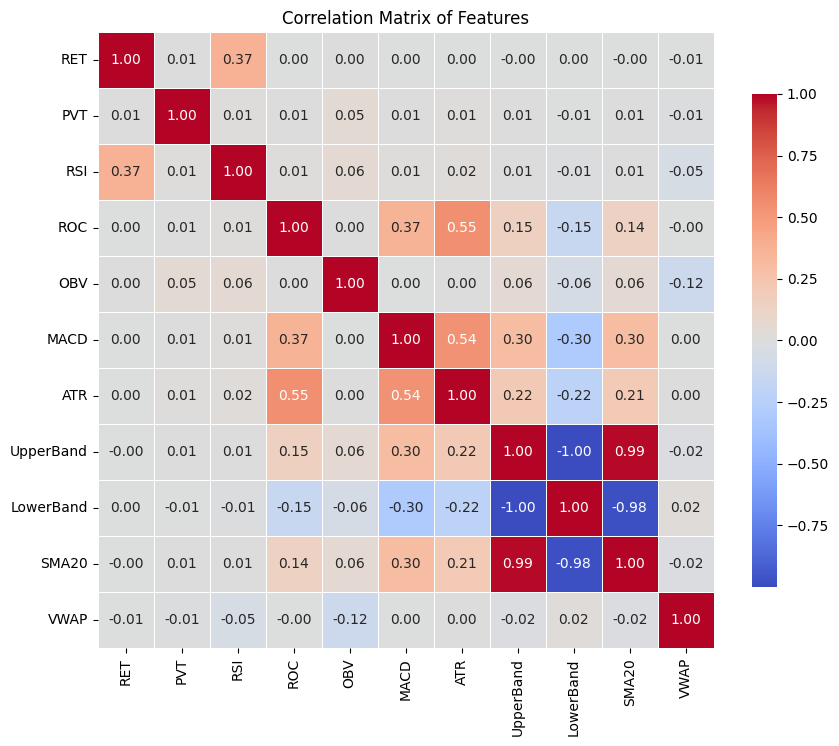

In [58]:
columns_of_interest = ['RET', 'PVT', 'RSI', 'ROC', 'OBV', 'MACD', 'ATR', 'UpperBand', 'LowerBand', 'SMA20','VWAP']

# Select only these columns for correlation calculation
correlation_matrix = resulting_df[columns_of_interest].corr()
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Adding title for context
plt.title('Correlation Matrix of Features')

# Show plot
plt.show()
#"PVT","RSI","SMA20","VWAP","ATR","RET"

In [20]:
filtered_df.to_parquet('../data/technical_stock_data.parquet')

In [36]:
import statsmodels.api as sm

# Choose the independent variable, for example, 'ATR'
X = filtered_df['RSI']
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Choose the dependent variable
Y = filtered_df['RET']

# Conduct the regression
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                 5.555e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:49:21   Log-Likelihood:             7.8317e+05
No. Observations:              373874   AIC:                        -1.566e+06
Df Residuals:                  373872   BIC:                        -1.566e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0355      0.000   -223.123      0.0

# Word2Vec Embeddings

In [12]:
from gensim.models import Word2Vec

# Load the trained Word2Vec model
model = Word2Vec.load("../adjusted_stock_embeddings.model")

In [14]:
import numpy as np

# Example DataFrame
df = pd.read_parquet('../stock_data_w_alphas.parquet')

# Initialize a list to hold the embeddings
embeddings = []

# Iterate over the DataFrame
for ticker in df['TICKER']:
    if ticker in model.wv:  # Check if the model has the ticker
        embedding = model.wv[ticker]
    else:
        embedding = np.zeros(model.vector_size)  # Use a zero vector if the ticker is not in the model
    embeddings.append(embedding)

# Convert the list of embeddings into a numpy array
embeddings = np.array(embeddings)

# Add the embeddings as new features to the DataFrame. This results in a DataFrame where each row represents a day/stock and includes the embedding vector as features.
# Note: This will expand the embeddings into separate columns for each dimension of the embedding.
for i in range(embeddings.shape[1]):  # For each dimension in the embedding
    df[f'emb_{i}'] = embeddings[:, i]

In [15]:
df

,date,TICKER,S_DQ_CLOSE,RET,alpha001,alpha002,alpha003,alpha004,alpha005,alpha006,...,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
124471,2001-01-26,SUNW,31.18750,0.000000,0.433086,0.386525,-0.237328,-5.0,-0.444184,-0.304482,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
124913,2001-01-29,SUNW,33.56250,0.076152,0.856081,-0.503691,-0.304077,-5.0,-0.444717,-0.358804,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
125879,2001-01-30,SUNW,32.06250,-0.044693,0.618694,-0.343073,-0.066061,-7.0,-0.447516,-0.218272,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
126189,2001-01-31,SUNW,30.56250,-0.046784,0.433086,-0.361457,-0.063250,-4.0,-0.446583,-0.238734,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
135113,2001-02-27,SUNW,19.81250,-0.045181,0.252788,-0.433718,0.673484,-4.0,-0.433786,0.623345,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133113,2016-12-22,NTES,217.10001,-0.026981,0.595618,-0.041233,0.266548,-6.0,-0.386488,0.267122,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2133490,2016-12-23,NTES,223.67000,0.030263,0.848606,0.304483,-0.068472,-5.0,-0.360475,-0.051078,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134129,2016-12-27,NTES,223.99001,0.001431,0.848606,0.142212,0.395631,-9.0,-0.397637,0.454995,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134924,2016-12-28,NTES,223.92000,-0.000313,0.595618,0.095192,0.547896,-8.0,-0.405070,0.586525,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621


In [16]:
df = df.drop(columns=df.filter(like='alpha').columns)

In [17]:
df

,date,TICKER,S_DQ_CLOSE,RET,1D_forward_return,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
124471,2001-01-26,SUNW,31.18750,0.000000,-0.070764,1.525310,-0.612527,2.872295,-1.253325,0.825628,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
124913,2001-01-29,SUNW,33.56250,0.076152,0.046784,1.525310,-0.612527,2.872295,-1.253325,0.825628,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
125879,2001-01-30,SUNW,32.06250,-0.044693,0.049080,1.525310,-0.612527,2.872295,-1.253325,0.825628,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
126189,2001-01-31,SUNW,30.56250,-0.046784,0.542587,1.525310,-0.612527,2.872295,-1.253325,0.825628,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
135113,2001-02-27,SUNW,19.81250,-0.045181,-0.003145,1.525310,-0.612527,2.872295,-1.253325,0.825628,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133113,2016-12-22,NTES,217.10001,-0.026981,-0.029374,-0.048115,-0.102475,0.028629,0.194354,-0.124991,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2133490,2016-12-23,NTES,223.67000,0.030263,-0.001429,-0.048115,-0.102475,0.028629,0.194354,-0.124991,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134129,2016-12-27,NTES,223.99001,0.001431,0.000313,-0.048115,-0.102475,0.028629,0.194354,-0.124991,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134924,2016-12-28,NTES,223.92000,-0.000313,0.004126,-0.048115,-0.102475,0.028629,0.194354,-0.124991,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621


In [19]:
df=df.drop(['1D_forward_return','S_DQ_CLOSE'],axis=1)

In [22]:
df

,date,TICKER,RET,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
124471,2001-01-26,SUNW,0.000000,1.525310,-0.612527,2.872295,-1.253325,0.825628,1.064456,-2.778073,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
124913,2001-01-29,SUNW,0.076152,1.525310,-0.612527,2.872295,-1.253325,0.825628,1.064456,-2.778073,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
125879,2001-01-30,SUNW,-0.044693,1.525310,-0.612527,2.872295,-1.253325,0.825628,1.064456,-2.778073,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
126189,2001-01-31,SUNW,-0.046784,1.525310,-0.612527,2.872295,-1.253325,0.825628,1.064456,-2.778073,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
135113,2001-02-27,SUNW,-0.045181,1.525310,-0.612527,2.872295,-1.253325,0.825628,1.064456,-2.778073,...,-1.324405,1.840051,-1.305009,-1.272032,0.232388,-3.453357,-1.717485,-0.249291,0.176502,0.624516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133113,2016-12-22,NTES,-0.026981,-0.048115,-0.102475,0.028629,0.194354,-0.124991,0.022221,0.016089,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2133490,2016-12-23,NTES,0.030263,-0.048115,-0.102475,0.028629,0.194354,-0.124991,0.022221,0.016089,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134129,2016-12-27,NTES,0.001431,-0.048115,-0.102475,0.028629,0.194354,-0.124991,0.022221,0.016089,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621
2134924,2016-12-28,NTES,-0.000313,-0.048115,-0.102475,0.028629,0.194354,-0.124991,0.022221,0.016089,...,0.028340,-0.018812,-0.082137,-0.054498,0.070861,0.095508,-0.119153,0.152850,0.074185,0.017621


In [ ]:
df.drop('')

In [21]:
df.to_parquet('stock_data_w_embeddings.parquet')